#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, default_collate
from torchvision import datasets, transforms
from torchvision.transforms.v2 import MixUp, CutMix
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform, CustomRegularizeTransform

import matplotlib.pyplot as plt

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN(fcn_depth=3, fcn_width=[1024, 512]) # initialise model

transform1 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((100, 100), antialias=True),
    transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(0.5),
    # most of the pictures are rotation invariant
    # moreover, rotation transformation increases the epoch time by more than ~1 minute
    # transforms.RandomRotation((-30, 30)),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), antialias=True),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])

# default pytorch value alpha = 1 is suboptimal for this
# alpha = 0.4 -> accuracy ~ 0.6
# alpha = 0.2 -> accuray ~ 0.67 (!!!)
alpha = 0.2

def mixup_collate_fn(batch):
    return MixUp(num_classes=102, alpha=alpha)(*default_collate(batch))

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform1) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform2) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform2)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

# Uncomment below if you have some CUDA memory allocation errors
# Also try to experiment with the value to maximize GPU usage
# os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:256'

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=mixup_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Visualize the original images and their transformed version

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


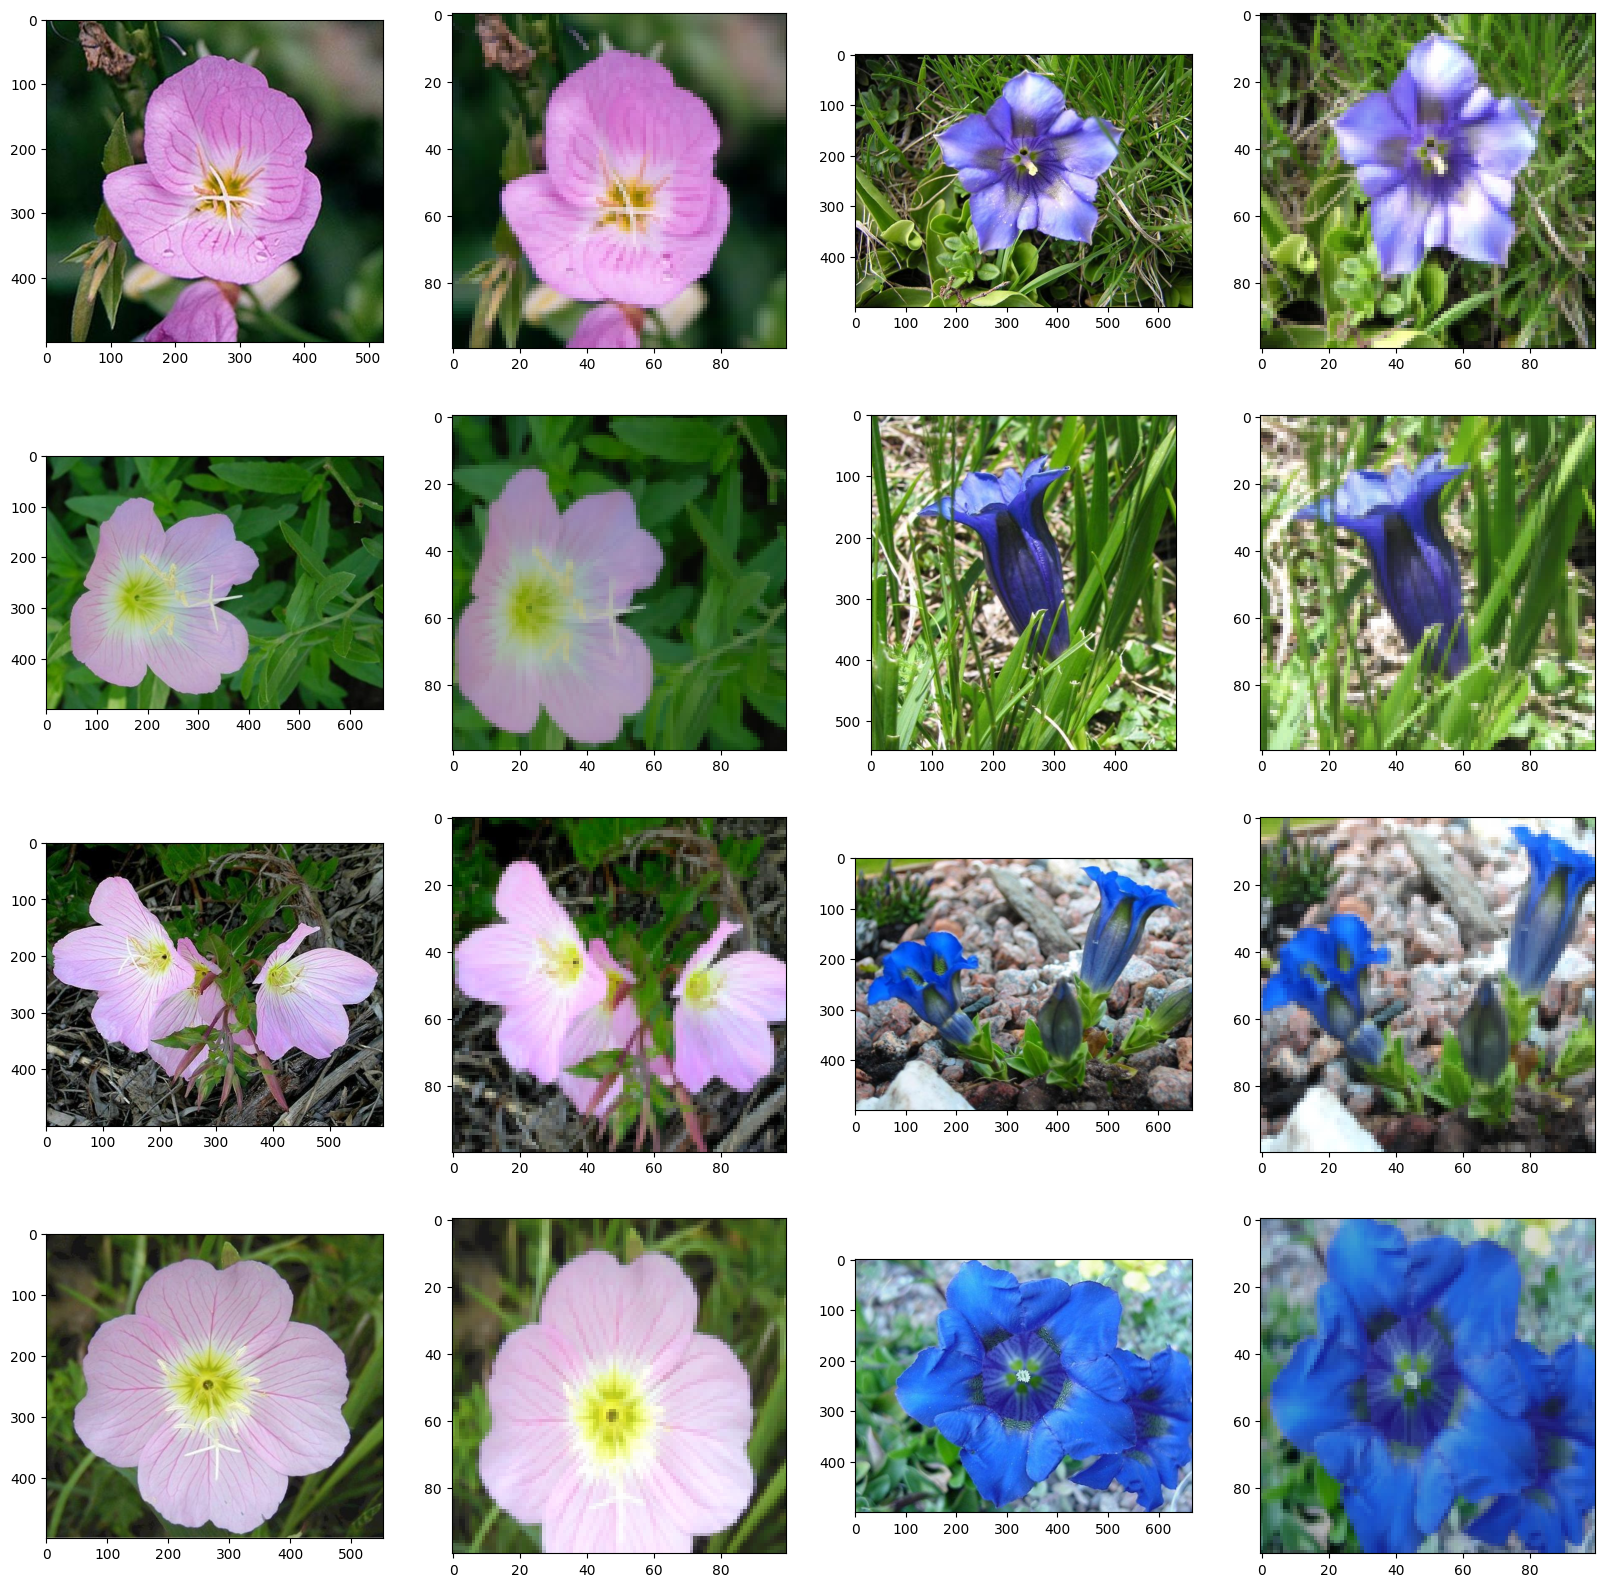

In [3]:
from itertools import product

train_dataset_ = datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor()) 

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
offset = 1000 # Change this to get different images

for i, j in product(range(4), range(2)):
    axs[i][2*j].imshow(train_dataset_[i+j*offset][0].permute(1, 2, 0))
    axs[i][2*j+1].imshow(train_dataset[i+j*offset][0].permute(1, 2, 0))

Visualize MixUp/Cutup. For alpha = 1, the mix-up is visible. For alpha <= 0.4, it is hard to notice the mix-up by eye.

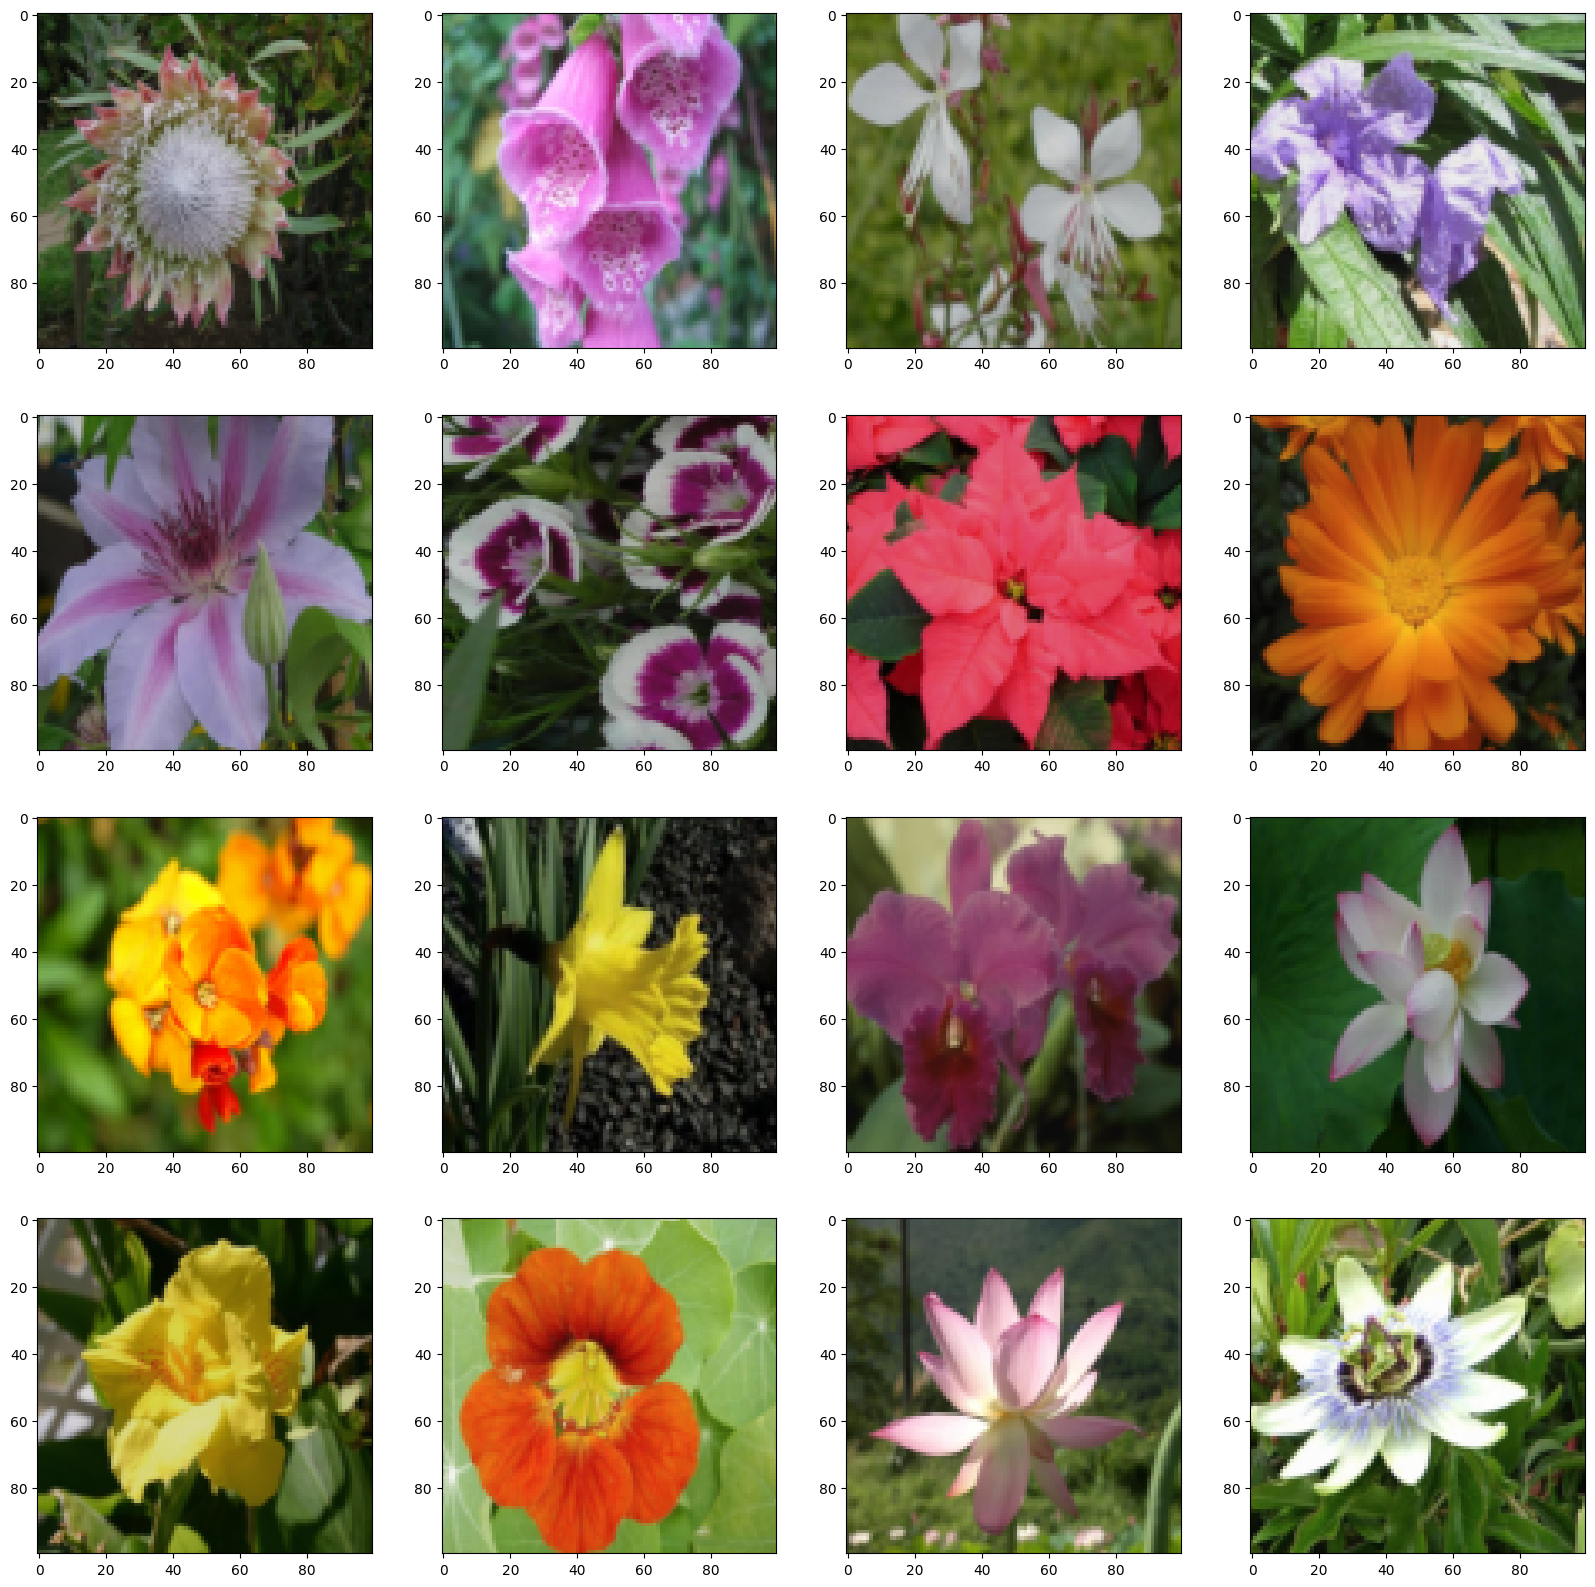

In [4]:
train_dataloader_ = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=mixup_collate_fn)

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for imgs, labs in train_dataloader_:
    for i, j in product(range(4), range(4)):
        axs[i][j].imshow(imgs[4*i+j].permute(1, 2, 0))
    break

Specify hyperparameters

In [5]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=10) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.makedirs(baseline_model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

model

CustomCNN(
  (conv_stack): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=3)
    (2): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
    (8): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gro

Train the model

In [6]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Training loss=3.9996]


Epoch 1/300 took 62.10s | Train loss: 3.9996 | Val loss: 5.5346 | Val accuracy: 1.57% | EarlyStopper count: 0


Epoch 2/300: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it, Training loss=3.2734]


Epoch 2/300 took 61.33s | Train loss: 3.2734 | Val loss: 4.7072 | Val accuracy: 4.90% | EarlyStopper count: 0


Epoch 3/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=2.8098]


Epoch 3/300 took 57.64s | Train loss: 2.8098 | Val loss: 2.7941 | Val accuracy: 28.24% | EarlyStopper count: 0


Epoch 4/300: 100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Training loss=2.7224]


Epoch 4/300 took 57.82s | Train loss: 2.7224 | Val loss: 2.3560 | Val accuracy: 38.33% | EarlyStopper count: 0


Epoch 5/300: 100%|██████████| 49/49 [00:54<00:00,  1.10s/it, Training loss=2.5062]


Epoch 5/300 took 58.15s | Train loss: 2.5062 | Val loss: 2.0348 | Val accuracy: 45.20% | EarlyStopper count: 0


Epoch 6/300: 100%|██████████| 49/49 [00:52<00:00,  1.08s/it, Training loss=2.3276]


Epoch 6/300 took 57.19s | Train loss: 2.3276 | Val loss: 1.8714 | Val accuracy: 48.92% | EarlyStopper count: 0


Epoch 7/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=2.0837]


Epoch 7/300 took 58.66s | Train loss: 2.0837 | Val loss: 1.6803 | Val accuracy: 55.78% | EarlyStopper count: 0


Epoch 8/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=2.1789]


Epoch 8/300 took 57.61s | Train loss: 2.1789 | Val loss: 1.7303 | Val accuracy: 54.71% | EarlyStopper count: 0


Epoch 9/300: 100%|██████████| 49/49 [00:54<00:00,  1.10s/it, Training loss=1.9274]


Epoch 9/300 took 58.26s | Train loss: 1.9274 | Val loss: 1.4610 | Val accuracy: 60.69% | EarlyStopper count: 1


Epoch 10/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=1.8695]


Epoch 10/300 took 58.27s | Train loss: 1.8695 | Val loss: 1.4442 | Val accuracy: 61.47% | EarlyStopper count: 0


Epoch 11/300: 100%|██████████| 49/49 [00:55<00:00,  1.12s/it, Training loss=1.9708]


Epoch 11/300 took 59.16s | Train loss: 1.9708 | Val loss: 1.3558 | Val accuracy: 63.92% | EarlyStopper count: 0


Epoch 12/300: 100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Training loss=1.7015]


Epoch 12/300 took 57.95s | Train loss: 1.7015 | Val loss: 1.3100 | Val accuracy: 64.51% | EarlyStopper count: 0


Epoch 13/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=1.7932]


Epoch 13/300 took 57.79s | Train loss: 1.7932 | Val loss: 1.4613 | Val accuracy: 60.10% | EarlyStopper count: 0


Epoch 14/300: 100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Training loss=2.0552]


Epoch 14/300 took 57.85s | Train loss: 2.0552 | Val loss: 1.5353 | Val accuracy: 59.22% | EarlyStopper count: 1


Epoch 15/300: 100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Training loss=2.1542]


Epoch 15/300 took 57.95s | Train loss: 2.1542 | Val loss: 1.3343 | Val accuracy: 64.41% | EarlyStopper count: 2


Epoch 16/300: 100%|██████████| 49/49 [00:53<00:00,  1.08s/it, Training loss=1.7234]


Epoch 16/300 took 57.15s | Train loss: 1.7234 | Val loss: 1.2296 | Val accuracy: 66.47% | EarlyStopper count: 3


Epoch 17/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=1.5898]


Epoch 17/300 took 57.55s | Train loss: 1.5898 | Val loss: 1.2126 | Val accuracy: 66.86% | EarlyStopper count: 0


Epoch 18/300: 100%|██████████| 49/49 [00:52<00:00,  1.08s/it, Training loss=1.5181]


Epoch 18/300 took 57.00s | Train loss: 1.5181 | Val loss: 1.2420 | Val accuracy: 65.98% | EarlyStopper count: 0


Epoch 19/300: 100%|██████████| 49/49 [00:54<00:00,  1.11s/it, Training loss=1.2923]


Epoch 19/300 took 58.69s | Train loss: 1.2923 | Val loss: 1.1177 | Val accuracy: 70.10% | EarlyStopper count: 1


Epoch 20/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=1.6039]


Epoch 20/300 took 57.91s | Train loss: 1.6039 | Val loss: 1.1530 | Val accuracy: 68.14% | EarlyStopper count: 0


Epoch 21/300: 100%|██████████| 49/49 [00:54<00:00,  1.12s/it, Training loss=1.4633]


Epoch 21/300 took 58.81s | Train loss: 1.4633 | Val loss: 1.1679 | Val accuracy: 69.22% | EarlyStopper count: 1


Epoch 22/300: 100%|██████████| 49/49 [00:54<00:00,  1.10s/it, Training loss=1.7627]


Epoch 22/300 took 58.11s | Train loss: 1.7627 | Val loss: 1.5435 | Val accuracy: 61.08% | EarlyStopper count: 2


Epoch 23/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=2.7252]


Epoch 23/300 took 57.79s | Train loss: 2.7252 | Val loss: 1.7912 | Val accuracy: 52.06% | EarlyStopper count: 3


Epoch 24/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=2.3023]


Epoch 24/300 took 57.64s | Train loss: 2.3023 | Val loss: 1.7327 | Val accuracy: 55.00% | EarlyStopper count: 4


Epoch 25/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=2.2163]


Epoch 25/300 took 57.42s | Train loss: 2.2163 | Val loss: 1.5797 | Val accuracy: 57.35% | EarlyStopper count: 5


Epoch 26/300: 100%|██████████| 49/49 [00:52<00:00,  1.07s/it, Training loss=2.1009]


Epoch 26/300 took 56.81s | Train loss: 2.1009 | Val loss: 1.4310 | Val accuracy: 61.86% | EarlyStopper count: 6


Epoch 27/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=1.9134]


Epoch 27/300 took 57.35s | Train loss: 1.9134 | Val loss: 1.3471 | Val accuracy: 63.24% | EarlyStopper count: 7


Epoch 28/300: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it, Training loss=1.7436]


Epoch 28/300 took 57.55s | Train loss: 1.7436 | Val loss: 1.3658 | Val accuracy: 63.43% | EarlyStopper count: 8


Epoch 29/300: 100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Training loss=2.0067]


Epoch 29/300 took 58.06s | Train loss: 2.0067 | Val loss: 1.5063 | Val accuracy: 59.31% | EarlyStopper count: 9
Early stopping


Plot train, test loss and test accuracy

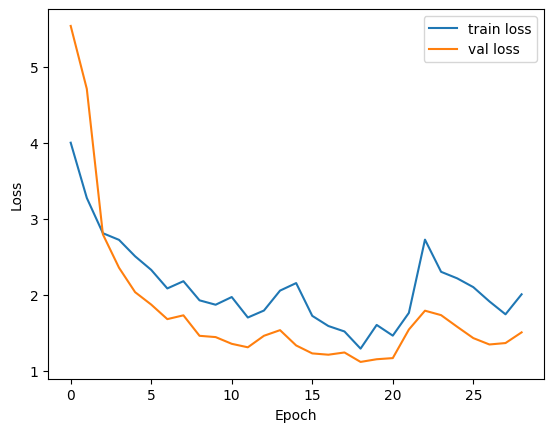

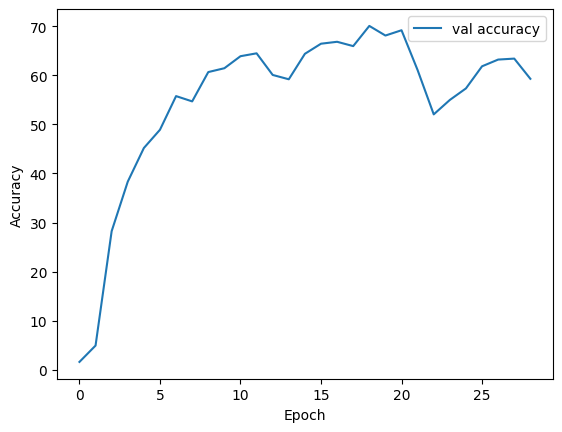

In [8]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()